In [1]:
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp


In [2]:
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [3]:
torch_geometric.__version__

'2.4.0'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
user_df = pd.read_json("./MOOCCube/entities/user.json",lines=True)
user_df = user_df[user_df['course_order'].apply(lambda x: len(x) >= 5)]
# user_df = user_df.sample(1500)
user = []
data_train = []
data_test = []
for index, row in user_df.iterrows():
    user_id = row["id"]
    courses = row["course_order"]

    index_partition = int(len(courses) * 0.75)

    courses_1 = courses[:index_partition]
    courses_2 = courses[index_partition:]
        
    for course in courses_1:
        data_train.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
            
    for course in courses_2:
            data_test.append({
                "user_id":user_id,
                "course_id":course,
                "view":1
            })
train_df = pd.DataFrame(data_train)
test_df = pd.DataFrame(data_test)

In [6]:
train_df.head()

,user_id,course_id,view
0,U_7001215,C_course-v1:TsinghuaX+00740043_2x_2015_T2+sp,1
1,U_7001215,C_course-v1:TsinghuaX+30240184+sp,1
2,U_7001215,C_course-v1:TsinghuaX+00740043X_2015_T2+sp,1
3,U_7423998,C_course-v1:TsinghuaX+30240184_2X+sp,1
4,U_7423998,C_course-v1:SCUT+145033+sp,1


In [7]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  187699
Test Size :  85698


In [8]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['course_id'].values)

In [9]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['course_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['course_id'].isin(train_item_ids))
]


34917 692


In [10]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['course_id'].values)

In [11]:
from bs4 import BeautifulSoup

In [12]:
course_df = pd.read_json("./MOOCCube/entities/course.json",lines=True)
# course_df = course_df.sample(100)
def remove_html_and_carriage_returns(text):
    soup = BeautifulSoup(text, "html.parser")
    text_without_html = soup.get_text().replace("\n","").replace("\r","").replace("\t","")
    
    return text_without_html

course_df["about"] = course_df["about"].apply(remove_html_and_carriage_returns)

In [13]:
course_df = course_df.rename(columns={'id': 'course_id'})

In [14]:
course_df = course_df[['course_id', 'about']]
course_df.head()

,course_id,about
0,C_course-v1:McGillX+ATOC185x+2015_T1,地球上没有一处地方不发生自然灾害。当我们以科学的眼光看待这些自然灾害的原因和本质时，我们可以更好地减轻灾难的后果。然而，随着世界人口持续增长，越来越多的人受到灾害的威胁。本门课程将探索不同类型自然灾害背后的科学原理，以及人类在控制、预测这些灾害方面的可为与不可为。学完课程后，学生可以深入理解自然灾害，而不仅仅是停留在新闻标题的了解。同时，还将学到减小自然灾害影响的方式。每一个人都应该理解自然灾害发生的科学原理。城市规划者需要知道房屋建造的合适位置。政治家需要做出科学合理的决策。紧急管理官员需要知道潜在灾难的本质，以及预防灾难的方式。记者则需要科学准确地进行报导。你将学到：● 探讨人类与自然之间的矛盾● 探讨自然灾害对全球的影响和它们之间的联系● 探讨自然灾害发生的科学原理
1,C_course-v1:TsinghuaX+THESIS2015X+2015_T1,学位论文答辩环节是研究生培养的重要环节，为了充分发挥该环节的育人作用，搭建学术交流的平台，进一步保障和提高研究生培养质量，清华大学研究生院从2014年开始，从申请学位的博士、硕士研究生中选取了部分具有代表性的学位论文答辩进行录像，并首次将答辩视频上传学堂在线，获得了社会各界的认可和积极反响。2015年，清华大学将继续这一形式，遴选不同专业的博士、硕士研究生的学位论文答辩视频，继续以MOOC形式共享呈现给大家，以使更多的人能够分享这些资源，搭建更为广阔的学术交流平台。如果这些视频能对您的学术研究有所帮助和启发，则是我们十分期待并愿意看到的事。
2,C_course-v1:TsinghuaX+THESIS2014_1X_tv+_2014_,学位论文答辩环节是研究生培养的重要环节，为了充分发挥该环节的育人作用，搭建学术交流的平台，进一步保障和提高研究生培养质量，清华大学研究生院从2014年春季学期申请学位的博士、硕士研究生中选取了部分具有代表性的学位论文答辩进行录像，并首次将答辩视频上传学堂在线，以使更多的人能够分享这些资源，搭建更为广阔的学术交流平台。本学期将会有来自经管学院、五道口金融学院、化学系、马克思主义学院、建筑学院、人文学院、交叉信息研究院、航天航空学院、计算机系、工程物理系、自动化系、物理系、新闻学院等不同院系的二十余名博士、硕士研究生的学位论文答辩视频，涵盖十余个学科。如果这些视频能对您的学术研究有所帮助和启发，则是我们十分期待并愿意看到的事。
3,C_course-v1:TsinghuaX+THESIS2015X_tv+2015_T1,学位论文答辩环节是研究生培养的重要环节，为了充分发挥该环节的育人作用，搭建学术交流的平台，进一步保障和提高研究生培养质量，清华大学研究生院从2014年开始，从申请学位的博士、硕士研究生中选取了部分具有代表性的学位论文答辩进行录像，并首次将答辩视频上传学堂在线，获得了社会各界的认可和积极反响。2015年，清华大学将继续这一形式，遴选不同专业的博士、硕士研究生的学位论文答辩视频，继续以MOOC形式共享呈现给大家，以使更多的人能够分享这些资源，搭建更为广阔的学术交流平台。如果这些视频能对您的学术研究有所帮助和启发，则是我们十分期待并愿意看到的事。
4,C_course-v1:TsinghuaX+00690242+sp,中国考古学是以往100年中发展最为迅速的领域之一，大批珍贵文物的出土，不断刷新人们对文化中国的认识。本课程以4-6件（组）精品文物作引子，将学术界探索中华文明的过程作为线索，介绍古代中国在造船、玉器等诸多领域的杰出成就，其中不乏学术前沿的考古发现与研究成果，内容精彩纷呈，雅俗共赏，学生可以藉此获得对文化中国全方位的、直观而深入的认识。


In [15]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  34917
Number of unique Items :  692


In [16]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([ 5654,  5903,  7732,  9345, 11418, 11556, 12279, 16455, 17107, 17154,
         19287, 22136, 22348, 27723, 28134, 29273], device='cuda:0'),
 tensor([35256, 35545, 35389, 34946, 35430, 35262, 35138, 35361, 35571, 35384,
         35379, 35154, 35084, 35531, 35596, 34944], device='cuda:0'),
 tensor([35031, 35476, 35231, 35159, 35003, 35063, 35468, 35329, 35434, 35554,
         35503, 35005, 34943, 35100, 35497, 35134], device='cuda:0'))

In [17]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[19930, 19930, 19930,  ..., 35310, 35359, 35309],
        [35292, 35376, 35289,  ..., 16020, 16020, 16020]], device='cuda:0')

In [18]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([35309, 16020], device='cuda:0'),
 tensor([19930, 35292], device='cuda:0'))

In [19]:
courses_df = train_df[["course_id","item_id_idx"]]
courses_df = courses_df.drop_duplicates()
courses_df = courses_df.sort_values(by='item_id_idx')
courses_df.head()

,course_id,item_id_idx
3370,C_course-v1:ACCA+FA1_X+2019_T1,0
174,C_course-v1:ACCA+FA1_X+sp,1
48051,C_course-v1:ACCA+FA1_X_en+2019_T1,2
26343,C_course-v1:ACCA+FA2_X+2019_T1,3
743,C_course-v1:ACCA+FA2_X+sp,4


In [20]:
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer

In [21]:
def generate_emdeding(x):
    encoder = SentenceTransformer("multi-qa-distilbert-cos-v1")
    encoding = encoder.encode(x)
    return encoding

In [22]:
courses_df = pd.merge(course_df, courses_df, on='course_id')

In [23]:
courses_df['Embeding'] = courses_df['about'].apply(generate_emdeding)
courses_df.head()

,course_id,about,item_id_idx,Embeding
0,C_course-v1:McGillX+ATOC185x+2015_T1,地球上没有一处地方不发生自然灾害。当我们以科学的眼光看待这些自然灾害的原因和本质时，我们可以更好地减轻灾难的后果。然而，随着世界人口持续增长，越来越多的人受到灾害的威胁。本门课程将探索不同类型自然灾害背后的科学原理，以及人类在控制、预测这些灾害方面的可为与不可为。学完课程后，学生可以深入理解自然灾害，而不仅仅是停留在新闻标题的了解。同时，还将学到减小自然灾害影响的方式。每一个人都应该理解自然灾害发生的科学原理。城市规划者需要知道房屋建造的合适位置。政治家需要做出科学合理的决策。紧急管理官员需要知道潜在灾难的本质，以及预防灾难的方式。记者则需要科学准确地进行报导。你将学到：● 探讨人类与自然之间的矛盾● 探讨自然灾害对全球的影响和它们之间的联系● 探讨自然灾害发生的科学原理,235,"[0.071099095, 0.045627654, -0.025804209, 0.019912144, 0.023929657, 0.047645174, -0.03153027, 0.04472491, 0.024610737, 0.00235305, 0.0038403028, -0.0139184, 0.054300066, 0.024639757, -0.012881841, -0.0040011657, 0.02467138, 0.0034925016, -0.07578477, 0.041752513, -0.013365047, -0.0036100738, 0.018155195, -0.030935913, -0.0022385588, 0.00548243, 0.0281437, 0.028872957, -0.011148159, -0.018112915, 0.0040080776, -0.018258454, -0.0171683, 0.078677565, -0.0054164645, -0.014956379, -0.0528779, -0.01714934, -0.00628942, -0.014603979, 0.01162315, -0.024080528, -0.0150970705, -0.0053883367, 0.03110884, -0.0446023, -0.07423419, 0.008557178, -0.050984368, 0.029384585, 0.02344477, -0.016709225, 0.00873408, 0.039978545, -0.021139612, 0.01087657, -0.028035507, -0.027565727, 0.018102618, -0.032542873, 0.03287173, -0.014196324, 0.0665755, 0.030548949, 0.02920337, 0.010397931, 0.030145662, 0.002189817, -0.061636236, -0.017756213, 0.03262114, 0.018413879, 0.0042475113, 0.038428996, -0.05617535, -0.03846715, -0.034370814, -0.0082929395, -0.065043405, 0.0016477004, -0.029632064, 0.02652638, -0.029006341, -0.023467142, -0.02746766, 0.02338986, 0.022733599, -0.0042824973, -0.009304722, 0.0068964195, 0.005537682, 0.029010033, 0.004015722, 0.004298106, -0.091236904, 0.004101904, 0.007124332, 0.009972428, 0.007751289, 0.029224558, ...]"
1,C_course-v1:TsinghuaX+THESIS2015X+2015_T1,学位论文答辩环节是研究生培养的重要环节，为了充分发挥该环节的育人作用，搭建学术交流的平台，进一步保障和提高研究生培养质量，清华大学研究生院从2014年开始，从申请学位的博士、硕士研究生中选取了部分具有代表性的学位论文答辩进行录像，并首次将答辩视频上传学堂在线，获得了社会各界的认可和积极反响。2015年，清华大学将继续这一形式，遴选不同专业的博士、硕士研究生的学位论文答辩视频，继续以MOOC形式共享呈现给大家，以使更多的人能够分享这些资源，搭建更为广阔的学术交流平台。如果这些视频能对您的学术研究有所帮助和启发，则是我们十分期待并愿意看到的事。,585,"[0.07524611, 0.067769185, -0.030330934, 0.012247148, 0.051828817, 0.03279862, -0.042217825, 0.08014868, -0.008701346, 0.023913585, 0.00052548974, -0.021346897, 0.07049786, 0.022277363, -0.029595986, 0.011015288, 0.028469723, 0.011257889, -0.025695508, 0.013092883, -0.032746334, 0.0035111692, 0.052147858, -0.039666448, -0.012750446, 0.031740908, 0.012134079, 0.038433872, 0.007397683, -0.041767735, -0.009189324, 0.013097966, -0.0033983854, 0.09529859, -0.036111094, -0.02027031, -0.03291927, -0.0059553236, 0.00017311126, -0.005630369, -0.012447486, -0.050240442, -0.015831728, -0.023710197, 0.027281834, -0.058711156, -0.055773992, 2.5905725e-05, -0.039266877, 0.04327915, -0.011532533, -0.006593268, -0.000513077, 0.014028271, -0.020205263, 0.0188994, -0.021267062, -0.0034210172, 0.0029852595, -0.017186483, 0.020844705, -0.0011180209, 0.024782201, 0.024360757, 0.029597277, 0.00410809, 0.031744577, -0.0053249984, -0.046451915, -0.023760546, 0.028362159, 0.0095456615, -0.018535856, -0.0017179174, -0.039220918, -0.0494804, -0.032562915, -0.0043701157, -0.025317969, -0.010690494, -0.0036627818, 0.010683045, -0.003084305, -0.025450448, -0.046091244, 0.054223154, 0.027269911, 0.017730033, -0.012069714, 0.018774685, 0.0024233002, 0.003591446, 0.03176584, -0.020567155, -0.08614492, 0.0034565388, -0.012122212, 0.033614893, 0.0070925187, 0.013648017, ...]"
2,C_course-v1:TsinghuaX+THESIS2014_1X_tv+_2014_,学位论文答辩环节是研究生培养的重要环节，为了充分发挥该环节的育人作用，搭建学术交流的平台，进一步保障和提高研究生培养质量，清华大学研究生院从2014年春季学期申请学位的博士、硕士研究生中选取了部分具有代表性的学位论文答辩进行录像，并首次将答辩视频上传学堂在线，以使更多的人能够分享这些资源，搭建更为广阔的学术交流平台。本学期将会有来自经管学院、五道口金融学院、化学系、马克思主义学院、建筑学院、人文学院、交叉信息研究院、航天航空学院、计算机系、工程物理系、自动化系、物理系、新闻学院等不同院系的二十余名博士、硕士研究生的学位论文答辩视频，涵盖十余个学科。如果这些视频能对您的学术研究有所帮助和启发，则是我们十分期待并愿意看到的事。,584,"[0.07043429, 0.06283212, -0.018100373, 0.014901132, 0.028460685, 0.018871404, -0.04184666, 0.088138126, 0.002422975, 0.017459683, -0.00260006, -0.0053368895, 0.076912045, 0.019379064, -0.03

In [24]:
from sklearn.decomposition import PCA
import numpy as np
course_embeddings = courses_df['Embeding'].values
course_embeddings_cleaned = [np.array(embedding) for embedding in course_embeddings]
course_embeddings = np.array(course_embeddings_cleaned)
n_components = 64
pca = PCA(n_components=n_components)
pca.fit(course_embeddings)
embeddings_pca = pca.transform(course_embeddings)
course_embeddings_tensor = torch.Tensor(embeddings_pca).to(device)

In [25]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):  
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [26]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [27]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [28]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim, 
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)
    self.embedding.weight[:num_items].data.copy_(course_embeddings_tensor)
    self.embedding.weight[num_items:].data.normal_(0, 0.1)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight[n_items:], std=0.1) 


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF' 
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )
    
    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users], 
        out[pos_items], 
        out[neg_items], 
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [29]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) + 
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))
  
  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
      
  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
      
  return bpr_loss, reg_loss

In [30]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K,epoch,df_result):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)
  
  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]
  if df_result is None:
    df_result = topk_relevance_indices_df
    df_result = df_result.rename(columns={'top_rlvnt_itm': 'top_rlvnt_itm_'+str(epoch)})
  else:
    df_result = pd.merge(df_result, topk_relevance_indices_df[['user_ID', 'top_rlvnt_itm']], on='user_ID', how='left')
    df_result = df_result.rename(columns={'top_rlvnt_itm': 'top_rlvnt_itm_'+str(epoch)})

  # measure overlap between recommended (top-scoring) and held-out user-item 
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean(), df_result

In [46]:
latent_dim = 64
n_layers = 3 

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005 
K = 30

In [32]:
def recommend(user_embeddings,item_embeddings,user):
    user_emdedding = user_embeddings[user]
    scores = torch.matmul(user_emdedding, item_embeddings.T)
    sorted_indices = torch.argsort(scores, descending=True)
    top_N = 30
    recommended_item_indices = sorted_indices[:30]
    recommended_item_ids = le_item.inverse_transform(recommended_item_indices.cpu().numpy())
    return recommended_item_ids  

In [33]:
groupedTrain = train_df.groupby('user_id')['course_id'].apply(list).reset_index()
groupedTest = test_df.groupby('user_id')['course_id'].apply(list).reset_index()
def getUserCourses(user,df_user):
    return df_user.loc[df_user['id'] == user, 'course_order'].values[0]
def  getUserCoursesTest(user):
    return groupedTest.loc[groupedTest['user_id'] == user, 'course_id'].values[0]
def  getUserCoursesTrain(user):
    return groupedTrain.loc[groupedTrain['user_id'] == user, 'course_id'].values[0]

In [34]:
users_df = test_df[["user_id", "user_id_idx"]]
users_df = users_df.drop_duplicates()
users_df.head()

,user_id,user_id_idx
0,U_7001215,19930
2,U_7423998,22589
4,U_545306,14759
7,U_7594103,23312
9,U_3234246,10534


In [35]:
def evaluate(df_user,us_em,it_em):
    # df_user = df_user.sample(500)
    results = []
    i = 0
    for index, row in df_user.iterrows():
        courses_train = getUserCoursesTrain(row["id"])
        courses_test = getUserCoursesTest(row["id"])
        resultado = users_df[users_df['user_id'] == row["id"]]['user_id_idx'].iloc[0]
        # print(resultado)
        recommended = list(recommend(us_em,it_em,int(resultado)))
        for j in courses_train:
            if j in recommended:
                recommended.remove(j)
        # print(len(recommended))
        recommended = recommended[:15]
        matches = list(set(courses_test).intersection(set(recommended)))
        results.append(
            {
                "recomendations":len(recommended),
                "matches":len(matches),
                "posible":len(courses_test)
            }
        )
        
    return results  

In [36]:
def get_precision(user_df,us_em,it_em):
    results = evaluate(user_df,us_em,it_em)
    df_evaluations = pd.DataFrame(results)
    cont = 0
    pre = 0
    for index, row in df_evaluations.iterrows():
        if row["posible"] < 15:
            precision = row["matches"]/row["posible"]
        else:
            precision = row["matches"]/15
        pre = pre + precision
        cont += 1
    return pre/cont

In [37]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []
  my_precision = []
  df_result = None
  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(train_df.shape[0]/BATCH_SIZE)
    
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []
      
      model.train()
      for batch_idx in range(n_batch):
          # print(batch_idx)

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision,result_df = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K,epoch,df_result
          )
          users_embedings = final_user_Embed
      df_result = result_df
      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))
      # mp = get_precision(user_df,final_user_Embed,final_item_Embed)
      my_precision.append(0)

  return (
    loss_list_epoch, 
    bpr_loss_list_epoch, 
    reg_loss_list_epoch, 
    recall_list, 
    precision_list,final_user_Embed,final_item_Embed,my_precision,result_df
  )

In [38]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([35609, 64])]


In [47]:
light_loss, light_bpr, light_reg, light_recall, light_precision,us_em,it_em,my_precision,result_df = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [48]:
epoch_list = [(i+1) for i in range(EPOCHS)]

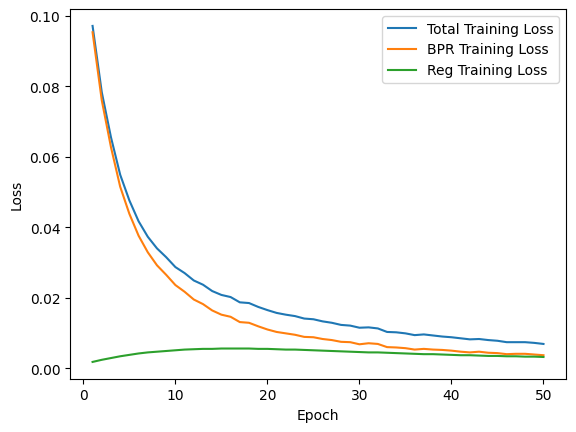

In [49]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

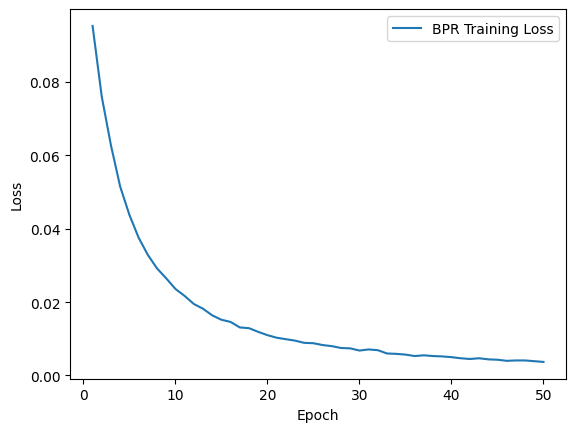

In [73]:
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

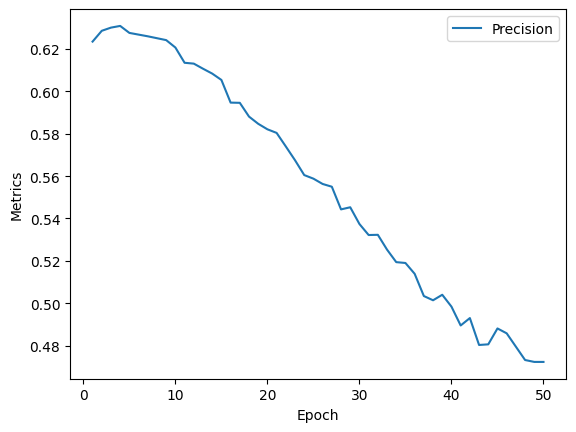

In [50]:
plt.plot(epoch_list, light_recall, label='Precision')
# plt.plot(epoch_list, my_precision, label='Precision')
pre = light_recall
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [51]:
print(max(pre))

0.6309


In [52]:
courses_df = train_df[["course_id","item_id_idx"]]
courses_df = courses_df.drop_duplicates()
courses_df = courses_df.sort_values(by='item_id_idx')
courses_df.head()

users_ids_df = train_df[["user_id","user_id_idx"]]
users_ids_df = users_ids_df.drop_duplicates()
users_ids_df = users_ids_df.sort_values(by='user_id_idx')
users_ids_df.head()

,user_id,user_id_idx
152102,U_10000144,0
107316,U_10000168,1
45857,U_10000185,2
53320,U_10000205,3
118854,U_10000338,4


In [53]:
def map_ids_to_names(ids_list):
    return [courses_df.loc[courses_df['item_id_idx'] == id, 'course_id'].values[0] for id in ids_list]

In [54]:
for i in range(EPOCHS):
    result_df['top_rlvnt_itm_'+str(i)] = result_df['top_rlvnt_itm_'+str(i)].apply(map_ids_to_names)

In [55]:
result_df =  pd.merge(result_df, users_ids_df, right_on='user_id_idx',left_on="user_ID", how='inner')

In [56]:
result_df["courses_test"] = result_df["user_id"].apply(getUserCoursesTest)
result_df["courses_train"] = result_df["user_id"].apply(getUserCoursesTrain)

In [67]:
precision_list = []
rank_list = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:15])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 15:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/15
        num_users += 1
        t_precision += precision
        
        r = 0
        found = False
        while r < len(row["top_rlvnt_itm_"+str(e)]) and not found:
            if row["top_rlvnt_itm_"+str(e)][r] in row["courses_test"]:
                found = True
            r += 1
        rank += 1/r
    precision_list.append(t_precision/num_users)
    rank_list.append((1/num_users)*rank)

In [68]:
precision_list_5 = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:5])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 5:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/5
        num_users += 1
        t_precision += precision
        
        
    precision_list_5.append(t_precision/num_users)

In [69]:
precision_list_10 = []
for e in range(EPOCHS):
    num_users = 0
    t_precision = 0
    rank = 0
    for index, row in result_df.iterrows():
        test_courses = set(row["courses_test"])
        taken_course =set(row["courses_train"])
        recommended = row["top_rlvnt_itm_"+str(e)]
        if set(recommended).intersection(taken_course):
            print("dios")
        for j in recommended:
            if j in taken_course:
                recommended.remove(j)
        # print(len(recommended))
        recommendations =set(recommended[:10])
        
        
        # print(len(test_courses))
        precision = len(test_courses.intersection(recommendations))/len(test_courses)
        if len(test_courses) < 10:
            precision = len(test_courses.intersection(recommendations))/len(test_courses)
        else:
            precision = len(test_courses.intersection(recommendations))/10
        num_users += 1
        t_precision += precision
        
        
    precision_list_10.append(t_precision/num_users)

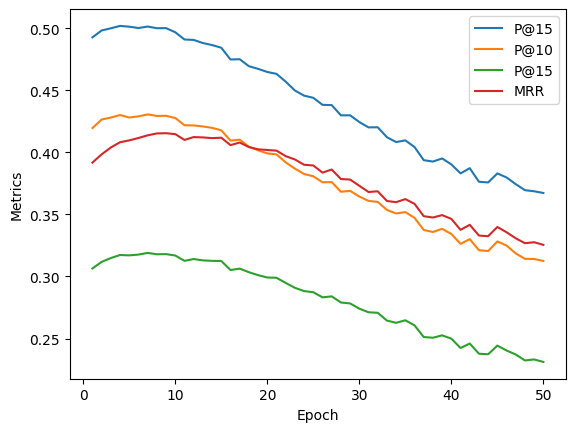

In [70]:
plt.plot(epoch_list, precision_list, label='P@15')
plt.plot(epoch_list, precision_list_10, label='P@10')
plt.plot(epoch_list, precision_list_5, label='P@15')
plt.plot(epoch_list, rank_list, label='MRR')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [59]:
print(max(precision_list))

0.5017723176671535


In [71]:
print(max(precision_list_5))

0.3189425399280215


In [72]:
print(max(precision_list_10))

0.43051792663873073
